## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,gen,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [578]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
import scipy
from scipy.sparse import coo_matrix
import moments

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})


In [349]:
N = 5000
s = -10/N # 25/N -> gamma = 50 - strong selection
mu = 1.25e-8 # human mutation rate
n = 20 # 2 * # of inds sampled, diploid

# start in generation 10 so generation 11 has all zeros (going back in time)
tot_gen = 10000
time_steps = np.linspace(0, tot_gen-1, 100, dtype=int)

mom = np.zeros((tot_gen+1,n+1))
momnp1 = np.zeros(n+1)
momkp1 = np.zeros((tot_gen+1,n+1))

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

In [177]:
np.linspace(10,1,dtype=int)

array([10,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,
        6,  6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  3,
        3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1])

In [5]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [43]:
# code borrowed from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx  
def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

In [350]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = 1 # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:
    momkp1[gen,iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

    momkp1[gen,1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
    momkp1[gen,n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

    # notice the difference in indexing for LHS
    # momnp1[np.arange(1,n+1)] = (jk13[:,0] * mom[gen+1,np.array(ibis)-1] - jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1])
    momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

    # restricting SFS to positive entries 
    # momnp1.clip(min=0.0, out=momnp1)
    # momnp1[momnp1<0] = 0.0

    momkp1[gen,iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

    mom[gen,] = deepcopy(momkp1[gen,])

mom2 = deepcopy(mom)

In [360]:
from ipynb.fs.defs.new-model import get_ll_xl

SyntaxError: invalid syntax (2883019281.py, line 1)

In [127]:
## code to run APR's moments and compare with output from above
# initialize the spectrum, with 1 in singleton bin
fs = moments.Spectrum(np.zeros(2*n + 1))
fs[1] = n*1
# simulate a generations
T = tot_gen / 2 / N
# set relative size to 1, theta to 0 to forbid new mutations
fs.integrate([1], T, gamma=s*2*N, h=0.5, theta=0, adapt_dt=True, dt_fac=0.005)

In [128]:
# fs.integrate([1], 0.01*T, gamma=s*2*N, theta=0, h=0.5)
fs = fs.project([n]) * 2

In [387]:
# moments.Spectrum(fsmat[1,:]).project([100])

(101,)

Text(0, 0.5, 'iterate')

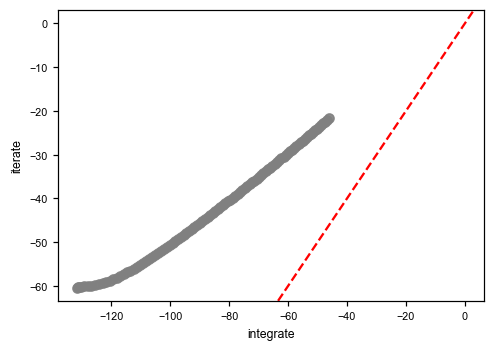

In [129]:
plt.scatter(np.log(np.abs(fs)), np.log(np.abs(mom[0,:])), color='grey', alpha=0.9)
plt.axline((0,0),slope=1,color='red',ls='--'); plt.xlabel('integrate'); plt.ylabel('iterate')

In [390]:
1/tot_gen

0.0001

In [319]:
# for dt in 
fsmat = np.zeros((tot_gen,n+1))
for idt, dt in enumerate(np.linspace(1e-3*T,T,tot_gen)[::-1]):
    fs = moments.Spectrum(np.zeros(n + 1))
    fs[1] = n*1
    fs.integrate([1], dt, gamma=0.5*s*2*N, h=0.5, theta=0, adapt_dt=False)
    fsmat[idt,:] = mu*fs

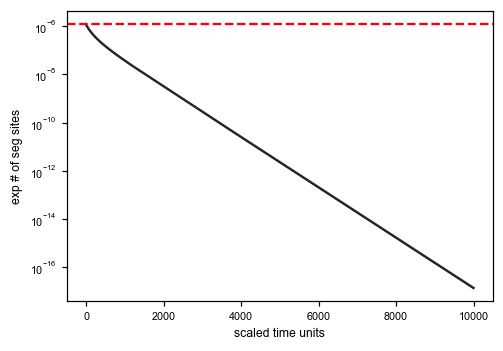

In [307]:
plt.plot(range(10000)[::-1],np.sum(fsmat[:,1:100],axis=1),color='black',alpha=1)
plt.plot(range(10000)[::-1],np.sum(mom2[1:,1:100],axis=1),color='grey',alpha=0.3)
plt.semilogy(); plt.xlabel('scaled time units'); plt.ylabel('exp # of seg sites')
plt.axhline(n*mu, color='red', ls='--',label='sample scaled mutation rate')

Text(0, 0.5, 'scaled time units')

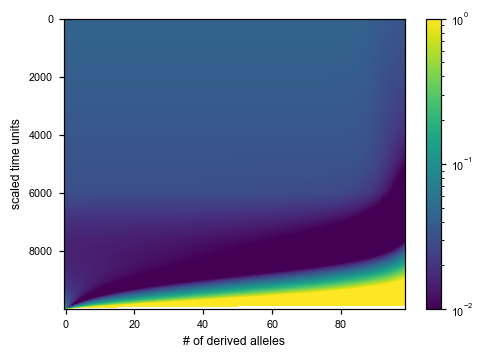

In [314]:
# np.sum(fsmat[:,1:],axis=1)
plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[:-2,1:100])/mom2[:-2,1:100],aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-2))
# plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[time_steps[:-1],1:100]),norm=colors.LogNorm(vmin=1e-20))
plt.colorbar(); plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units')

(array([9.89521e+05, 1.36000e+02, 5.50000e+01, 3.50000e+01, 2.70000e+01,
        2.00000e+01, 1.70000e+01, 1.30000e+01, 1.20000e+01, 8.00000e+00,
        6.00000e+00, 6.00000e+00, 6.00000e+00, 5.00000e+00, 4.00000e+00,
        4.00000e+00, 4.00000e+00, 3.00000e+00, 3.00000e+00, 3.00000e+00,
        3.00000e+00, 3.00000e+00, 2.00000e+00, 2.00000e+00, 3.00000e+00]),
 array([1.26052970e-144, 4.95844164e-009, 9.91688329e-009, 1.48753249e-008,
        1.98337666e-008, 2.47922082e-008, 2.97506499e-008, 3.47090915e-008,
        3.96675332e-008, 4.46259748e-008, 4.95844164e-008, 5.45428581e-008,
        5.95012997e-008, 6.44597414e-008, 6.94181830e-008, 7.43766247e-008,
        7.93350663e-008, 8.42935080e-008, 8.92519496e-008, 9.42103912e-008,
        9.91688329e-008, 1.04127275e-007, 1.09085716e-007, 1.14044158e-007,
        1.19002599e-007, 1.23961041e-007]),
 <BarContainer object of 25 artists>)

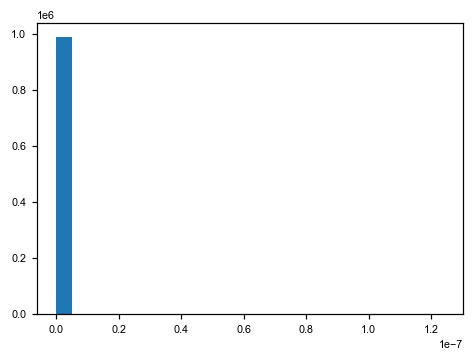

In [318]:
# np.where(np.max(np.abs(fsmat[:,1:100]-mom2[time_steps,1:100])))
# mom2[time_steps,2]
plt.hist(np.ravel(np.abs(fsmat[:-1,1:100]-mom2[:-2,1:100])),25)

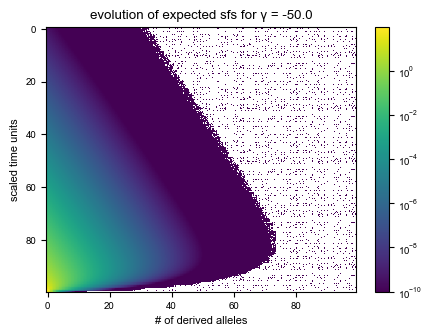

In [197]:
plt.figure(dpi=100)
plt.imshow((fsmat[-100:,1:]),aspect='auto',norm=colors.LogNorm(vmin=1e-10))
plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

In [322]:
J = calcJK13(n)
S = 0.5 * s * calcS(n+1, J)
D = 0.25/N * calcD(n+1)

In [1194]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*1 # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:

    momkp1[gen,iter] = mom[gen+1,iter] + ((D[iter,] + S[iter,]) @ mom[gen+1,])
    # momkp1[gen,0] = momkp1[gen,n] = 0.0

    mom[gen,] = deepcopy(momkp1[gen,])

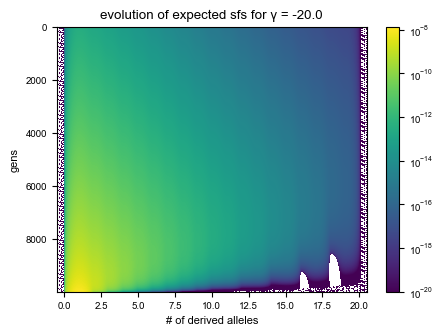

In [356]:
plt.figure(dpi=100)
plt.imshow((mom2[-10000:,:]),aspect='auto',norm=colors.LogNorm(vmin=1e-20))
plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

# plt.figure(dpi=100)
# plt.imshow((mom[-10000:,:]),aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-10))
# plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
# plt.colorbar(); plt.show()

# plt.figure(dpi=90)
# plt.scatter(np.arange(tot_gen+1)[::-1][-100000:],(np.sum(mom[-100000:,:],axis=1)),alpha=0.7,color='k')
# plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')
# plt.axhline(n*1, color='red', ls='--',label='sample scaled mutation rate')
# plt.axvline(0.5*N, color='grey',label='N/2'); plt.legend()
# plt.axvline(tot_gen-np.max(np.where(np.sum(mom,axis=1)<0)), color='coral', ls='-.')

Text(0, 0.5, '# of copies')

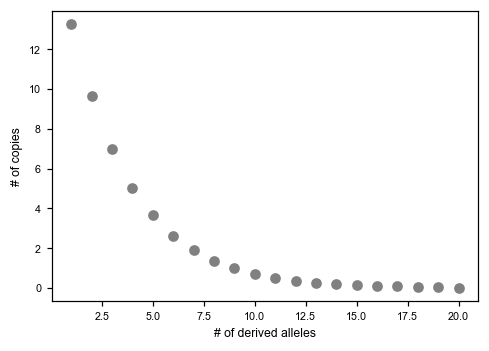

In [348]:
# plt.hist(np.ravel(mom[8000:10000,30:]))
plt.scatter(np.arange(1,n+1),10000*mom[-9900,1:],color='grey',label='iterate')
# plt.plot(np.arange(1,n+1),fs[1:],color='black',label='integrate')
plt.xlabel('# of derived alleles'); plt.ylabel('# of copies')
# plt.scatter(np.ravel(mom),np.ravel(mom2),alpha=0.5,color='grey'); plt.axline((0,0),(1,1),color='red')

In [9]:
def calcD(d):
    res = np.zeros([d, d])
    # loop over the fs elements:
    for i in range(d):
        if i > 1:
            res[i, i - 1] = (i-1) * (d-i)
        if i < d - 2:
            res[i, i + 1] = (i+1) * (d-i-2)
        if i > 0 and i < d - 1:
            res[i, i] = -2 * i * (d-i-1)
    return res

In [10]:
def calcS(d, ljk):
    # Computes the jackknife-transformed selection matrix 1
    # for the addition of a single sample
    # arrays for the creation of the sparse (coo) matrix
    # data will have matrix entry, row + column have coordinates
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        i_bis = index_bis(i, d - 1) # This picks the second jackknife index 
        i_ter = index_bis(i + 1, d - 1) # This picks the third jackknife index
        # coefficients of the selection matrix
        g1 = i * (d-i) / np.float64(d)
        g2 = -(i+1) * (d-1-i) / np.float64(d)

        if i < d - 1 and i > 0: # First deal with non-fixed variants
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                    g1 * ljk[i - 1, i_bis], g2 * ljk[i, i_ter - 1],
                    g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 6 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1,
                    i_ter, i_ter - 1, i_ter + 1]
        
        elif i == 0: # g1=0
            data += [g2 * ljk[i, i_ter - 1],
                     g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 3 * [i]
            col += [i_ter, i_ter - 1, i_ter + 1]
        
        elif i == d - 1: # g2=0
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                     g1 * ljk[i - 1, i_bis]]
            row += 3 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1]

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [505]:
## packaging into a function for easy manipulation - iteration implementation 
# input: a (number of gens), n (number of samples), s, N (pop size)
# output: mom (number of sites)
def run_mom_iterate(a, n, s, N, mu, misc):
    mom = np.zeros((a+1,n+1))
    momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    J = calcJK13(n)

    iter = np.arange(1,n)
    iterm1p1 = np.arange(2,n-1)

    mom[a,1] = n # singleton input

    # going from generation 9 to 0
    for gen in np.arange(a)[::-1]:
        momkp1[iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

        momkp1[1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
        momkp1[n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

        # notice the difference in indexing for LHS
        momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

        momkp1[iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

        mom[gen,] = deepcopy(momkp1)

    return mu*mom[:-1,:]           

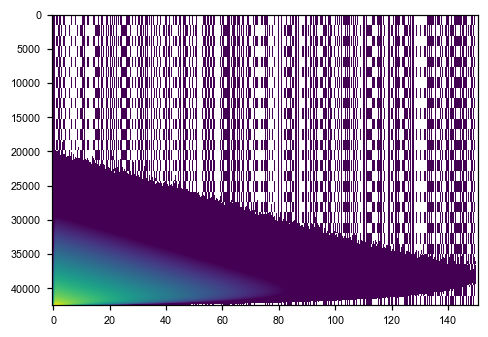

In [646]:
# fs = run_mom_integrate(2500, 120, -10/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
mom = run_mom_iterate(42500, 150, 0.5*gamma[21]/N, N, mu, np.nan)
plt.imshow((mom),aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30))
# fs.shape, mom.shape
# plt.scatter(mom[-2000,1:-1], fs2[-2000,1:-1], color='grey', alpha=0.75) #plt.loglog()
# plt.axline((0,0),slope=1,color='red',ls='--')

In [468]:
# fs2 = deepcopy(fs)
# mom[-10000,1:-1], fs2[-10000,1:-1]

array([1.0000e-04, 2.0000e-04, 3.0000e-04, ..., 2.4998e+00, 2.4999e+00,
       2.5000e+00])

In [394]:
def run_mom_integrate(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    for idt, dt in enumerate(np.linspace(0.5/N,0.5*a/N,a)[::-1]):
        fs = moments.Spectrum(np.zeros(n + 1))
        fs[1] = n*1
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = mu*fs
    return fsmat

In [682]:
## creating a database of P(X, a | s) with dicts for different s values
p_xa_s = {}
# gamma = -np.exp(np.log(10)*np.linspace(2, -2, 25))
for g in gamma:
    p_xa_s[g] = run_mom_iterate(42500, 150, 0.5*g/N, N, mu, np.nan)
    # can project down to any sample size using moments.Spectrum(p_xa_s[g][-1,:]).project([20])*120/20

### Reading in simulation data for comparison

In [528]:
import pandas as pd
df1 = pd.read_csv("traindata/trip-2021-10-20.csv")
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])

In [678]:
# gamma = np.unique(dat[:,1])
gamma[0]

-100.0

In [516]:
## function to obtain the log P(X,|gamma)
def get_lp_xl(g, Xlred, N=2500):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(len(Xlred))

    ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    scalfact = (ub - lb)/np.expm1(2.*g)

    # return a vector...
    for ix, x in enumerate(Xlred):
        res[ix] = (1-np.exp(-2*g*(1-x)))/(x*(1-x)*(1-np.exp(-2*g)))

    return np.log(res/scalfact)

(array([1.5315e+04, 1.4320e+03, 8.6700e+02, 6.0700e+02, 5.0400e+02,
        3.7800e+02, 3.3200e+02, 2.6900e+02, 2.3200e+02, 2.1000e+02,
        2.0700e+02, 1.8100e+02, 1.6900e+02, 1.5700e+02, 1.3300e+02,
        1.4100e+02, 9.8000e+01, 1.0500e+02, 1.2200e+02, 9.3000e+01,
        9.1000e+01, 9.7000e+01, 6.9000e+01, 7.2000e+01, 7.4000e+01,
        6.5000e+01, 7.2000e+01, 5.9000e+01, 6.0000e+01, 6.2000e+01,
        6.4000e+01, 5.7000e+01, 3.4000e+01, 3.8000e+01, 4.8000e+01,
        4.6000e+01, 5.8000e+01, 3.7000e+01, 4.3000e+01, 3.8000e+01,
        3.8000e+01, 4.9000e+01, 4.5000e+01, 3.5000e+01, 3.8000e+01,
        3.3000e+01, 3.8000e+01, 3.9000e+01, 4.2000e+01, 3.3000e+01,
        2.6000e+01, 2.8000e+01, 2.2000e+01, 2.9000e+01, 3.2000e+01,
        2.2000e+01, 2.7000e+01, 3.6000e+01, 2.5000e+01, 2.6000e+01,
        2.9000e+01, 1.8000e+01, 2.2000e+01, 2.5000e+01, 1.9000e+01,
        1.9000e+01, 2.2000e+01, 3.2000e+01, 3.0000e+01, 1.6000e+01,
        1.8000e+01, 2.1000e+01, 1.8000e+01, 1.60

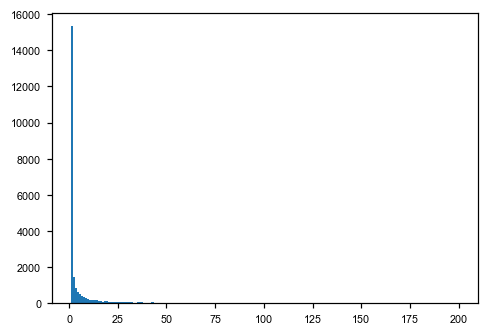

In [573]:
## don't need a function since the dict already exists
Xsamp = np.arange(1,200+1)/200
plt.hist([np.argmin(np.abs(dat[i,0]-Xsamp))+1 for i in range(len(dat))],bins=200)

In [580]:
trueg1 = -0.01
trueg2 = -100.
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
# newdf1 = newdf1.sample(frac=1)

# only keeping alleles with ages > 1 (cos NN & PRF approx finds really high prob for these alleles to have small gamma...)
newdat = newdf1.loc[newdf1['al']>0,:].to_numpy()

In [601]:
## just doing a lookup of sorts for the right probability
def get_lp_alxl(g, Xlred, alred, n=120):
    Xsamp = np.arange(1,n+1)/n
    res = np.empty(len(Xlred))
    for i in range(len(Xlred)):
        res[i] = np.log(np.abs(p_xa_s[g][int(alred[i]),np.argmin(np.abs(Xlred[i]-Xsamp))+1]))

    return res

-1.4677992676220701


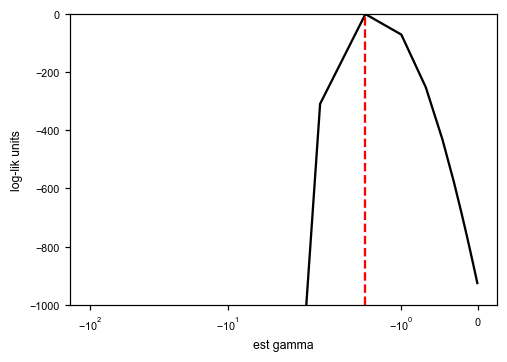

In [581]:
sin_onlyfreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(g, dat[:,0]))
plt.plot(gamma,sin_onlyfreq-np.max(sin_onlyfreq),'k')
plt.ylim((-1000,0))
plt.xlabel('est gamma')
plt.xscale('symlog')
plt.axvline(gamma[np.argmax(sin_onlyfreq)], color='red', linestyle='--')
plt.ylabel('log-lik units')
print(gamma[np.argmax(sin_onlyfreq)])

-0.01


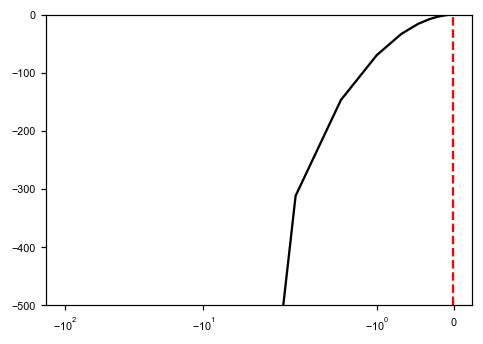

In [683]:
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,0], newdat[:,2], n=150))

plt.plot(gamma,sin_onlyage-np.max(sin_onlyage),'k')
plt.xscale('symlog')
plt.ylim((-500,0))
plt.axvline(gamma[np.argmax(sin_onlyage)], color='red', linestyle='--')
print(gamma[np.argmax(sin_onlyage)])

In [665]:
gamma = -np.exp(np.linspace(np.log(0.01),np.log(100),25))

In [684]:
preds_sin_onlyage = np.zeros(len(gamma[::2]))
for ig, g in enumerate(gamma[::2]):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    newdat = newdf1.loc[newdf1['al']>1,:].to_numpy()
    # newdat = newdf1.loc[np.logical_and(newdf1['al']>1, newdf1['al']<40),:].to_numpy()
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=150)) for g1 in gamma]
    preds_sin_onlyage[ig] = gamma[np.argmax(sin_onlyage)]

-100.0

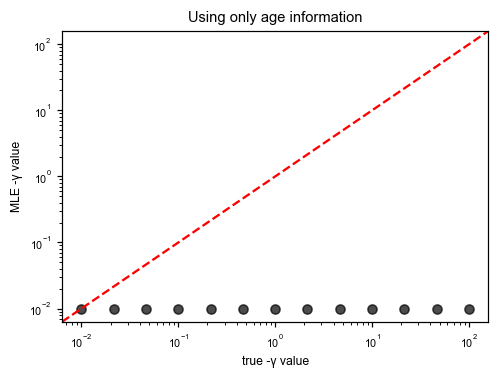

In [685]:
plt.scatter(-gamma[::2], -preds_sin_onlyage, color='k', alpha=0.7)
plt.xlabel('true -γ value')
plt.ylabel('MLE -γ value')
plt.yscale('log')
plt.xscale('log')
plt.title('Using only age information')
plt.axline((100,100),(0,0),color='red',ls='--')